## 教程7-对抗正则化图自动编码器（ARGA&ARVGA）

In [2]:
import os.path as osp
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import (v_measure_score, homogeneity_score, completeness_score)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models.autoencoder import ARGVA
from torch_geometric.utils import train_test_split_edges

/Volumes/Data/software/conda/miniconda3/envs/dl_env/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Volumes/Data/software/conda/miniconda3/envs/dl_env/lib/python3.10/site-packages/torch_scatter/_version_cpu.so, 0x0006): symbol not found in flat namespace '__ZN5torch3jit17parseSchemaOrNameERKNSt3__112basic_stringIcNS1_11char_traitsIcEENS1_9allocatorIcEEEEb'
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Volumes/Data/software/conda/miniconda3/envs/dl_env/lib/python3.10/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: dlopen(/Volumes/Data/software/conda/miniconda3/envs/dl_env/lib/python3.10/site-packages/torch_cluster/_version_cpu.so, 0x0006): symbol not found in flat namespace '__ZN5torch3jit17parseSchemaOrNameERKNSt3__112basic_stringIcNS1_11char_traitsIcEENS

In [3]:
use_cuda = False

### 定义数据集

In [4]:
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset.get(0)

In [5]:
# 获取节点数量
num_nodes = data.x.shape[0]
num_nodes

2708

In [6]:
# 创建 训练/验证/测试数据
data.train_mask = data.val_mask = data.test_mask = None
data = train_test_split_edges(data)

data

/Volumes/Data/software/conda/miniconda3/envs/dl_env/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[2708, 1433], y=[2708], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527])

### 定义模型

In [7]:
# 编码器
class VEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels, cached=True)
        self.conv_mu = GCNConv(2*out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2*out_channels, out_channels, cached=True)
    
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [8]:
# 判别器
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Discriminator, self).__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, out_channels)
    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

In [9]:
# 训练算法
def train():
    # 模型训练 - 标签为训练
    model.train()
    encoder_optimizer.zero_grad()

    z = model.encode(data.x, data.train_pos_edge_index)

    for i in range(5):
        idx = range(num_nodes)                                  # 选择所有节点
        discriminator.train()                                   # 确保判别器处于训练器
        discriminator_optimizer.zero_grad()                     # 清空判别器优化梯度
        discriminator_loss = model.discriminator_loss(z[idx])   # 计算判别器损失
        discriminator_loss.backward(retain_graph=True)          # 反向传播计算梯度
        discriminator_optimizer.step()                          # 更新判别器参数
    loss = 0
    # 添加编码器正则化损失，作用：防止编码过拟合
    loss = loss + model.reg_loss(z)
    # 添加图重构损失（核心训练目标）， 作用：使编码器能够重构训练正边
    loss = loss + model.recon_loss(z, data.train_pos_edge_index)
    # 添加KL散度损失（变分自编码器关键项）；作用：约束嵌入空间
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    # 计算总损失的梯度
    loss.backward()
    # 更新编码参数
    encoder_optimizer.step()
    
    return loss



In [15]:
@torch.no_grad()   # 禁用梯度计算
def test():
    model.eval()    #  模型切换评估模式
    # 生成嵌入表示
    z = model.encode(data.x, data.train_pos_edge_index)
    # === 节点聚类任务 ===
    kmeans_input = z.cpu().numpy()
    kmeans = KMeans(n_clusters = 7, random_state=0).fit(kmeans_input)   # 使用K-Means对编码后的节点进行聚类
    pred = kmeans.predict(kmeans_input)
    labels = data.y.cpu().numpy()
    # 评价 聚类质量指标（使用于无监督学习评估）
    completeness = completeness_score(labels, pred)
    hm = homogeneity_score(labels, pred)
    nmi = v_measure_score(labels, pred)

    # === 链接预测任务（监督评估）===
    auc, ap = model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

    return auc, ap, completeness, hm, nmi


### 初始化模型

In [11]:
# 编码器&判别器
latent_size = 32

encoder = VEncoder(data.num_features, out_channels=latent_size)
discriminator = Discriminator(in_channels=latent_size, hidden_channels=2*latent_size, out_channels=1)

In [12]:
# 初始化模型并将内容移至GPU
model = ARGVA(encoder, discriminator)
device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
model, data = model.to(device), data.to(device)

In [13]:
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.005)

In [16]:
# 训练模型
for epoch in range(1, 201):
    loss = train()
    auc, ap, completeness, hm, nmi = test()
    print(f'Epoch:{epoch:03d}, loss:{loss:.3f}, Auc:{auc:.3f}, Ap:{ap:.3f}, Completeness:{completeness:.3f}, Homogeneity:{hm:.3f}, Nmi:{nmi:.3f}')

Epoch:001, loss:4.725, Auc:0.689, Ap:0.717, Completeness:0.082, Homogeneity:0.082, Nmi:0.082
Epoch:002, loss:4.102, Auc:0.682, Ap:0.711, Completeness:0.080, Homogeneity:0.078, Nmi:0.079
Epoch:003, loss:3.503, Auc:0.682, Ap:0.711, Completeness:0.110, Homogeneity:0.109, Nmi:0.109
Epoch:004, loss:3.080, Auc:0.691, Ap:0.719, Completeness:0.129, Homogeneity:0.124, Nmi:0.127
Epoch:005, loss:2.693, Auc:0.713, Ap:0.740, Completeness:0.151, Homogeneity:0.150, Nmi:0.150
Epoch:006, loss:2.436, Auc:0.749, Ap:0.776, Completeness:0.208, Homogeneity:0.210, Nmi:0.209
Epoch:007, loss:2.212, Auc:0.769, Ap:0.794, Completeness:0.218, Homogeneity:0.221, Nmi:0.220
Epoch:008, loss:2.057, Auc:0.750, Ap:0.776, Completeness:0.243, Homogeneity:0.239, Nmi:0.241
Epoch:009, loss:1.990, Auc:0.729, Ap:0.757, Completeness:0.242, Homogeneity:0.238, Nmi:0.240
Epoch:010, loss:2.055, Auc:0.730, Ap:0.756, Completeness:0.245, Homogeneity:0.249, Nmi:0.247
Epoch:011, loss:2.169, Auc:0.752, Ap:0.773, Completeness:0.266, Homoge

In [18]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    # 生成节点嵌入表示
    z = model.encode(data.x, data.train_pos_edge_index)
    # === 降维处理 ===
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()
    # === 可视化配置 ===
    fig = plt.figure(1, figsize=(8,8))
    fig.clf()
    # === 按类别绘制散点图 ===
    for i in range(dataset.num_classes):
        plt.scatter(
            z[y==i, 0], z[y==i, 1],
            s=20, color=colors[i],
            label=f'Class {i}' if i == 0 else None
        )
    
    # === 优化图形 ===
    plt.axis('off')
    plt.tight_layout()
    plt.legend(loc='best', frameon=True)
    plt.show()

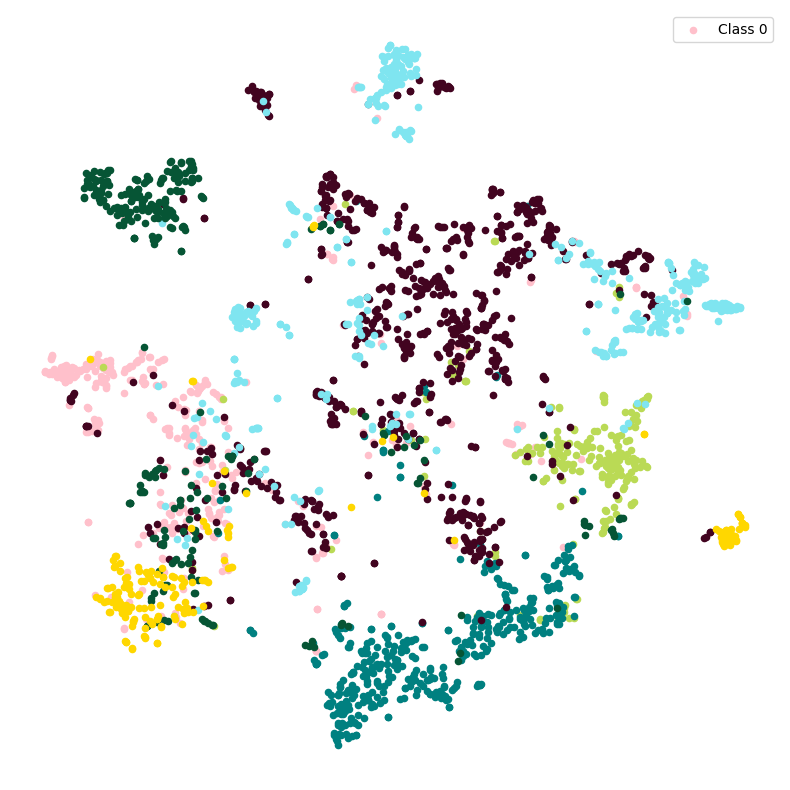

In [19]:
colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)